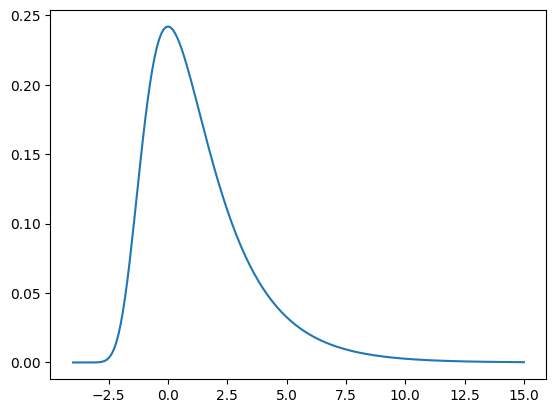

In [7]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm


def landau_dist_pdf(x):
    # u = 0 and c = 1
    p = 1 / np.sqrt(2 * np.pi) * np.exp(-1/2 * (x + np.exp(-1 * x)))
    return p

xs = np.linspace(-4,15, 200)
ys = landau_dist_pdf(xs)

plt.plot(xs, ys)

In [8]:
import torch
from scipy.stats import norm


def gassian_pdf(x, mean, variance):
    sigma = np.sqrt(variance)
    mu = mean
    pdf = 1 / (sigma * torch.sqrt(2 * np.pi)) * torch.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return pdf

def plot_dist(gmm, idx):
    # idx = 0
    mu = gmm.means_[idx,0]
    sigma = np.sqrt(gmm.covariances_[idx,0,0])
    weight = gmm.weights_[idx]

    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
    pdf_values = norm.pdf(x, loc=mu, scale=sigma)
    plt.plot(x, pdf_values * weight, label=f"ID={idx}, W={weight}")

def subset_dists(gmm, xs, indices):
    comb_pdf = np.zeros_like(xs)
    scale_factor = gmm.weights_[indices]
    scale_factor = scale_factor / scale_factor.sum()

    for order, idx in enumerate(indices):
        mu = gmm.means_[idx,0]
        sigma = np.sqrt(gmm.covariances_[idx,0,0])
        # weight = gmm.weights_[idx]
        weight = scale_factor[order]
        pdf_values = norm.pdf(xs, loc=mu, scale=sigma)
        comb_pdf += pdf_values * weight
    return comb_pdf

def gen_formula(gmm):
    comb_pdf = np.zeros_like(xs)
    items = []
    code = []

    for idx in range(len(gmm.means_)):
        mu = gmm.means_[idx,0]
        var = gmm.covariances_[idx,0,0]
        weight = gmm.weights_[idx]
        item = f"{weight:.3f} * Norm({mu:.3f}, {var:.3f})"
        items.append(item)
        code_item = f"{weight:.3f} * gassian_pdf(x, {mu:.3f}, {var:.3f})"
        code.append(code_item)
    formula = " + ".join(items)
    code_line = " + ".join(code)
    print("Math=", formula)
    print("Code=", code_line)



def plot_all_dists(gmm):
    for i in range(len(gmm.means_)):
        plot_dist(gmm, i)

In [9]:
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

def gaussian_mcmc(hops,lower,higher, eval_func):
    """
    eval_func: unnormalized pdf function
    """
    states = []
    burn_in = int(hops*0.2)
    current = random.uniform(lower,higher)
    for i in tqdm(list(range(hops))):
        states.append(current)
        movement = random.uniform(lower,higher)

        curr_prob = eval_func(current) # they are un-normed
        move_prob = eval_func(movement)

        acceptance = min(move_prob/curr_prob,1)
        if random_coin(acceptance):
            current = movement
    return np.array(states[burn_in:])


def sample_from_dist(pdf_func=landau_dist_pdf, plot=True):
    lower, higher = -4,15
    lines = np.linspace(lower,higher,10_000)
    target_pdf = pdf_func(lines)
    dist = gaussian_mcmc(1000_000,lower,higher,pdf_func)
    if plot:
        plt.hist(dist,density=True,bins=100)
        plt.plot(lines,target_pdf)
        plt.show()
    return dist

def split_dist(pdf_func=landau_dist_pdf, N_gaussian=2, plot=True):
    lower, higher = -4,15
    lines = np.linspace(lower,higher,10_000)
    target_pdf = pdf_func(lines)
    dist = sample_from_dist(pdf_func, plot)
    # Fit a Gaussian Mixture Model with two components
    gmm = GaussianMixture(n_components=N_gaussian)
    sample = np.random.choice(dist, 100000)
    gmm.fit(sample.reshape(-1, 1))

    # Compute the PDF using the GMM
    pdf = np.exp(gmm.score_samples(lines.reshape(-1, 1)))
    if plot:
        plt.figure()
        plt.plot(lines, pdf, 'r-', label='GMM PDF')
        plt.plot(lines,target_pdf, label='Origin')
        plt.legend()

        plt.show()

        plt.figure()

        plt.plot(lines,target_pdf, label='Origin')
        plt.plot(lines, pdf, 'r-', label='GMM PDF')
        plot_all_dists(gmm)
        plt.legend()
        plt.title("Decomposition")
        plt.show()

    gen_formula(gmm)


  0%|          | 0/1000000 [00:00<?, ?it/s]

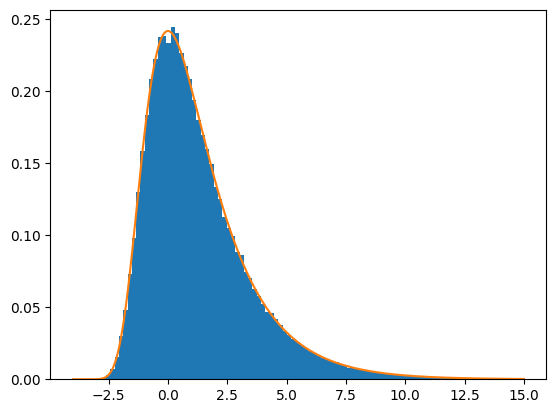

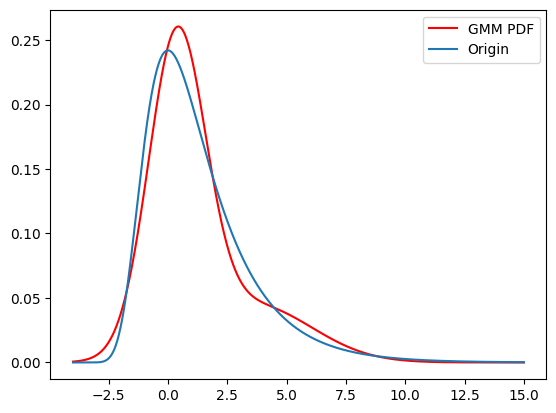

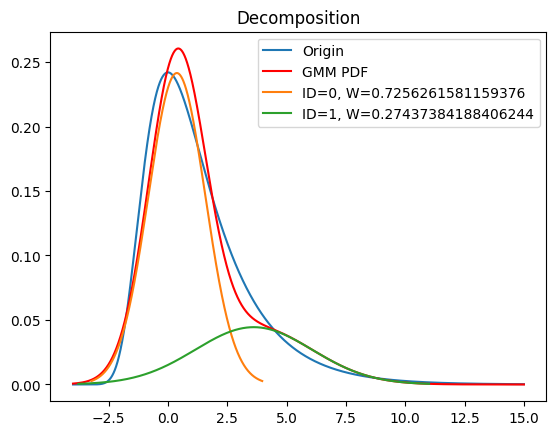

Math= 0.726 * Norm(0.375, 1.437) + 0.274 * Norm(3.613, 6.069)
Code= 0.726 * gassian_pdf(x, 0.375, 1.437) + 0.274 * gassian_pdf(x, 3.613, 6.069)


In [10]:
split_dist(landau_dist_pdf)

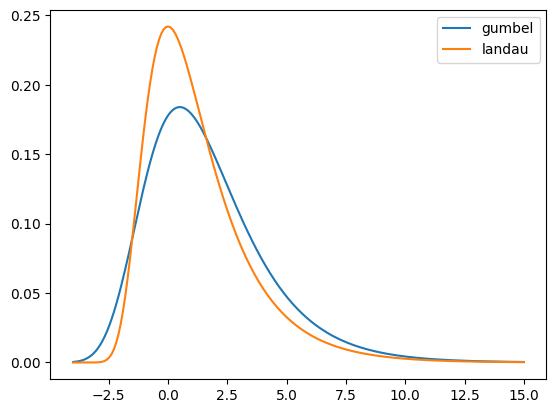

In [11]:
def gumbel_dist_pdf(x):
    u, beta = 0.5, 2.0
    z = (x - u) / beta
    return 1/beta * np.exp(-1 * (z + np.exp(-1 * z)))

xs = np.linspace(-4,15, 200)
ys = gumbel_dist_pdf(xs)
plt.plot(xs, ys, label='gumbel')

ys = landau_dist_pdf(xs)
plt.plot(xs, ys, label='landau')

plt.legend()

  0%|          | 0/1000000 [00:00<?, ?it/s]

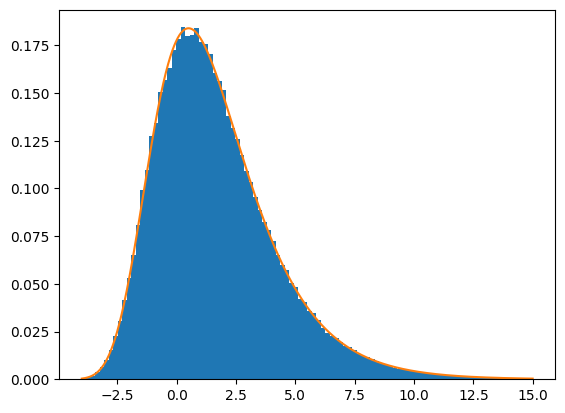

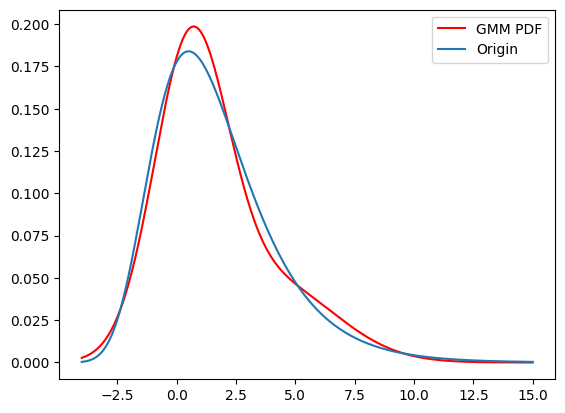

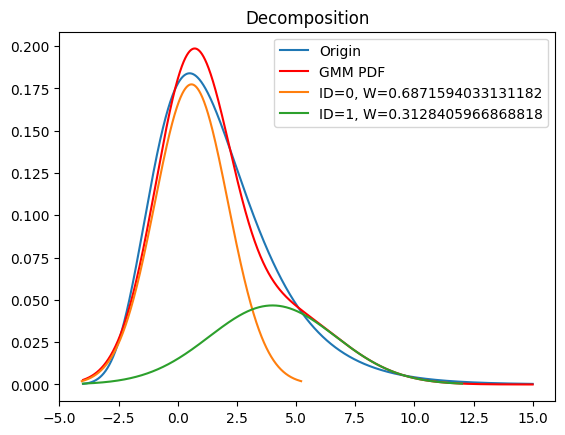

Math= 0.687 * Norm(0.578, 2.388) + 0.313 * Norm(4.003, 7.134)
Code= 0.687 * gassian_pdf(x, 0.578, 2.388) + 0.313 * gassian_pdf(x, 4.003, 7.134)


In [12]:
split_dist(gumbel_dist_pdf)

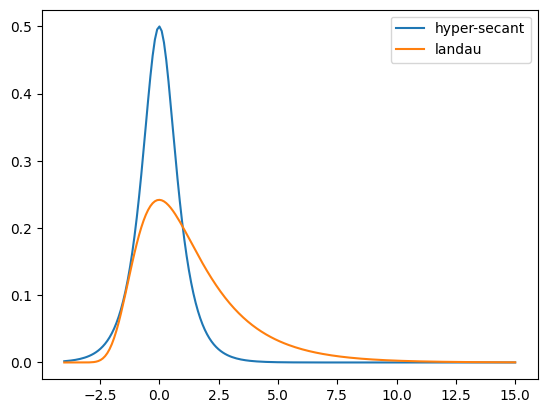

In [13]:
def sech(x):
    return 1 / np.cosh(x)

def hyper_secant_dist_pdf(x):
    return 1/2 * sech(np.pi / 2 * x)

xs = np.linspace(-4,15, 200)
ys = hyper_secant_dist_pdf(xs)
plt.plot(xs, ys, label='hyper-secant')

ys = landau_dist_pdf(xs)
plt.plot(xs, ys, label='landau')

plt.legend()

  0%|          | 0/1000000 [00:00<?, ?it/s]

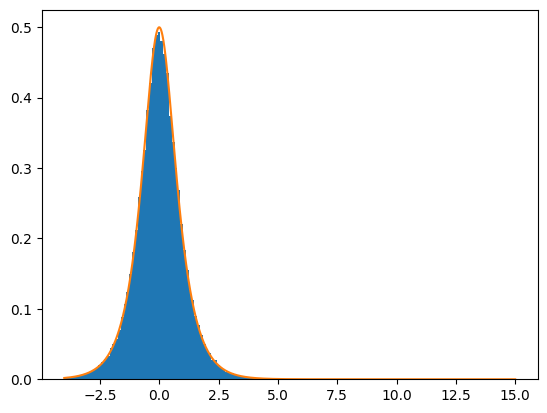

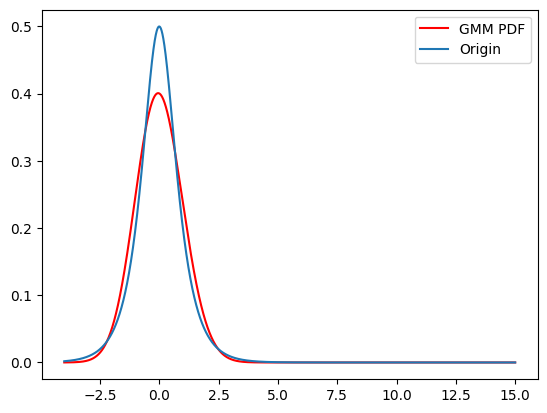

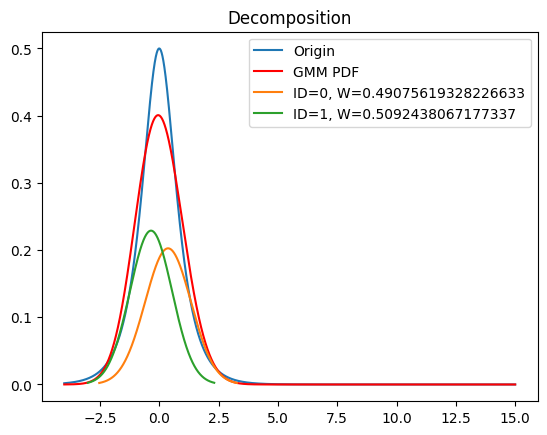

Math= 0.491 * Norm(0.373, 0.934) + 0.509 * Norm(-0.344, 0.788)
Code= 0.491 * gassian_pdf(x, 0.373, 0.934) + 0.509 * gassian_pdf(x, -0.344, 0.788)


In [14]:
split_dist(hyper_secant_dist_pdf)

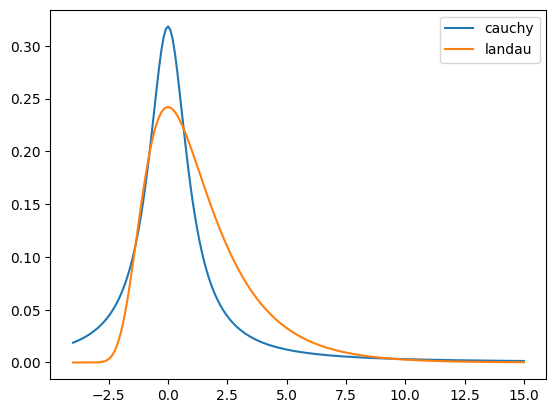

In [15]:
def cauchy_dist_pdf(x):
    x0, r = 0, 1
    z = (x - x0) / r
    q = 1 + z ** 2
    p = 1 / (np.pi * r * q)
    return p

xs = np.linspace(-4,15, 200)
ys = cauchy_dist_pdf(xs)
plt.plot(xs, ys, label='cauchy')

ys = landau_dist_pdf(xs)
plt.plot(xs, ys, label='landau')

plt.legend()

  0%|          | 0/1000000 [00:00<?, ?it/s]

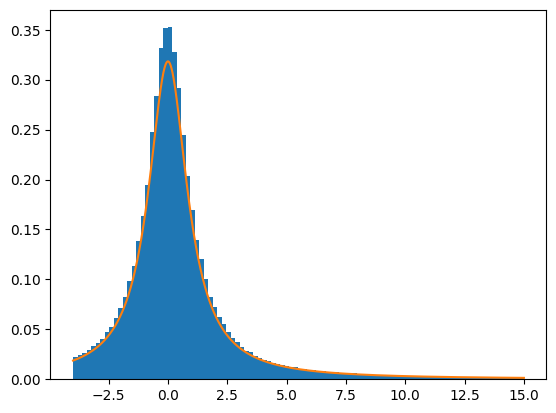

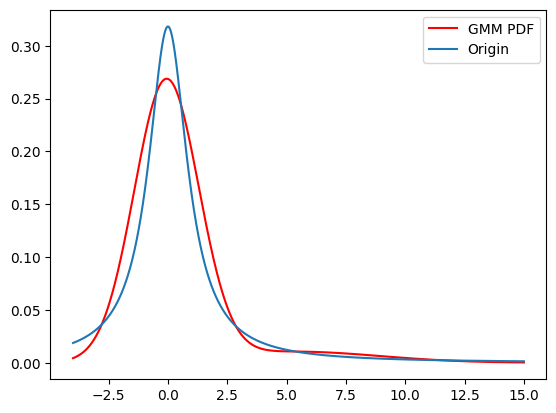

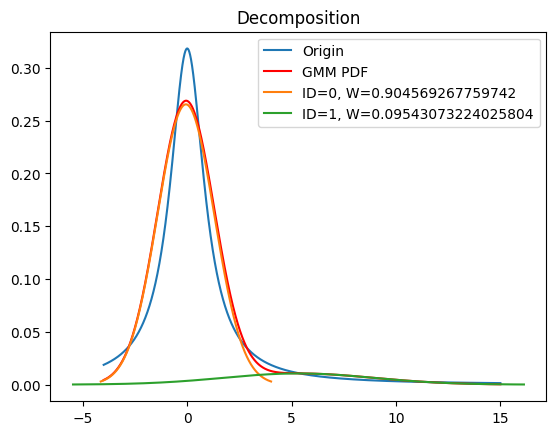

Math= 0.905 * Norm(-0.062, 1.849) + 0.095 * Norm(5.329, 12.955)
Code= 0.905 * gassian_pdf(x, -0.062, 1.849) + 0.095 * gassian_pdf(x, 5.329, 12.955)


In [16]:
split_dist(cauchy_dist_pdf)

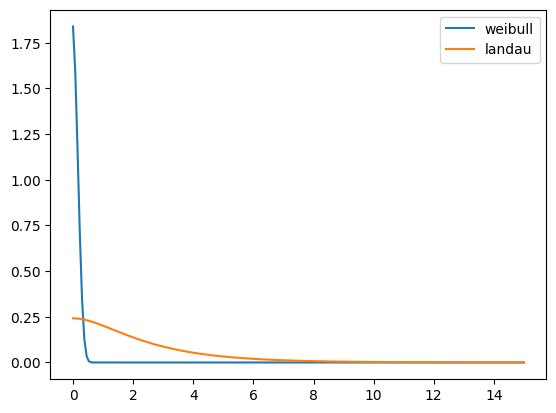

In [17]:
def weibull_dist_pdf(x):
    x = x + 1
    lambda_, k = 1, 5
    s = -1 * (x/lambda_) ** k
    p = k / lambda_ * (x / lambda_) ** (k-1) * np.exp(s)
    return p

xs = np.linspace(0,15, 200)
ys = weibull_dist_pdf(xs)
plt.plot(xs, ys, label='weibull')

ys = landau_dist_pdf(xs)
plt.plot(xs, ys, label='landau')

plt.legend()

  0%|          | 0/1000000 [00:00<?, ?it/s]

<ipython-input-9-f032dd927fa8>:22: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


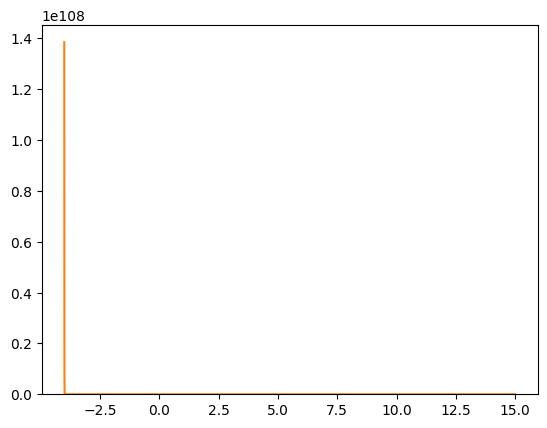

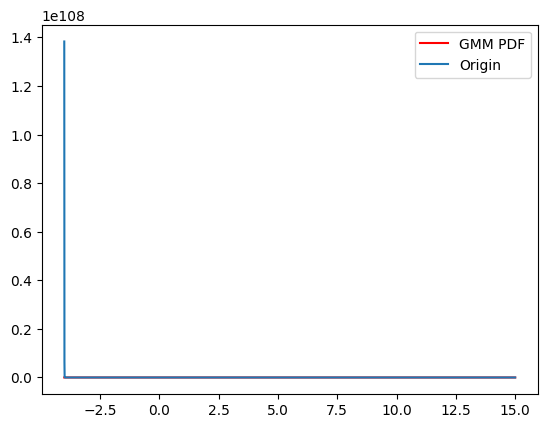

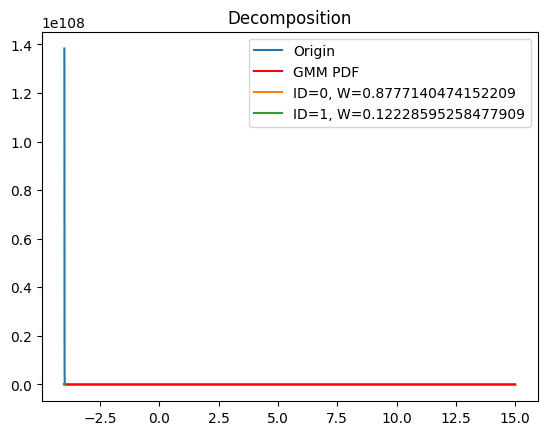

Math= 0.878 * Norm(-3.998, 0.000) + 0.122 * Norm(-3.994, 0.000)
Code= 0.878 * gassian_pdf(x, -3.998, 0.000) + 0.122 * gassian_pdf(x, -3.994, 0.000)


In [18]:
split_dist(weibull_dist_pdf)

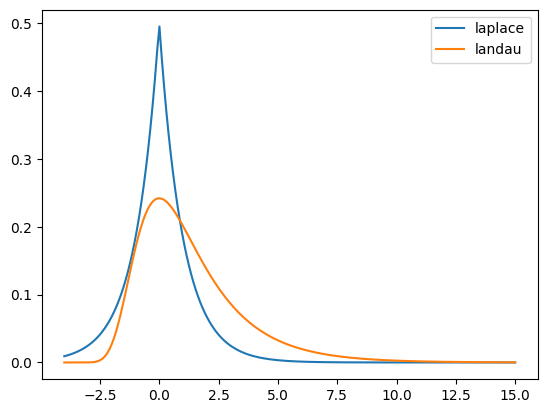

In [19]:
def laplace_dist_pdf(x):
    u, b = 0, 1
    s = np.abs(x - u) / b * -1
    p = 1/(2 * b) * np.exp(s)
    return p

xs = np.linspace(-4,15, 200)
ys = laplace_dist_pdf(xs)
plt.plot(xs, ys, label='laplace')

ys = landau_dist_pdf(xs)
plt.plot(xs, ys, label='landau')

plt.legend()

  0%|          | 0/1000000 [00:00<?, ?it/s]

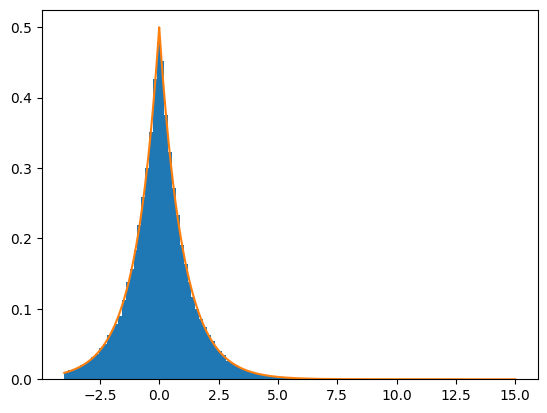

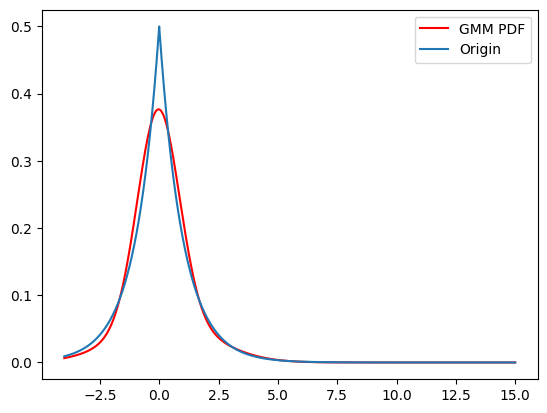

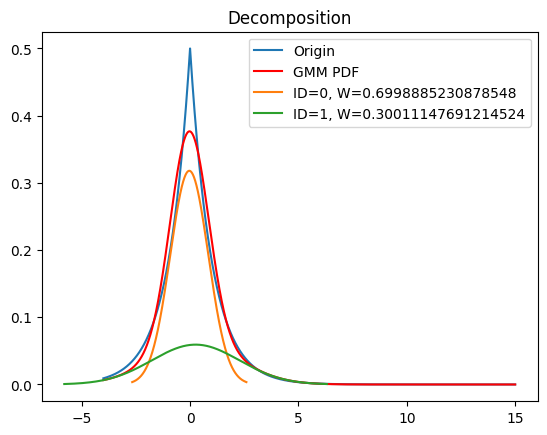

Math= 0.700 * Norm(-0.035, 0.771) + 0.300 * Norm(0.254, 4.078)
Code= 0.700 * gassian_pdf(x, -0.035, 0.771) + 0.300 * gassian_pdf(x, 0.254, 4.078)


In [20]:
split_dist(laplace_dist_pdf)

<ipython-input-21-bd927943d8b6>:5: RuntimeWarning: invalid value encountered in power
  c = (x - u) ** (3/2)


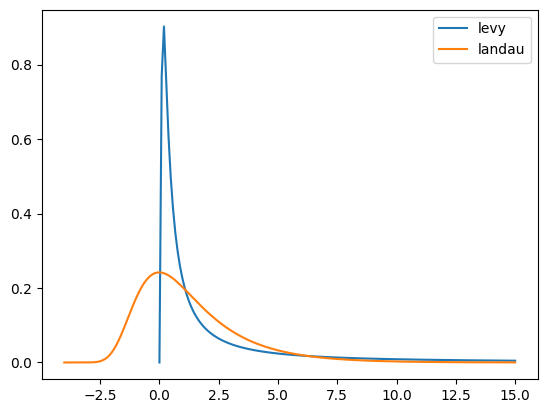

In [21]:
def levy_dist_pdf(x):
    c, u = 1/2, 0
    a = np.sqrt(c / (2 * np.pi))
    b = -1 * c / (2 * (x - u))
    c = (x - u) ** (3/2)
    return a * np.exp(b) / c


xs = np.linspace(-4,15, 200)
ys = levy_dist_pdf(xs)
plt.plot(xs, ys, label='levy')

ys = landau_dist_pdf(xs)
plt.plot(xs, ys, label='landau')

plt.legend()

<ipython-input-21-bd927943d8b6>:5: RuntimeWarning: invalid value encountered in power
  c = (x - u) ** (3/2)
<ipython-input-21-bd927943d8b6>:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b) / c


  0%|          | 0/1000000 [00:00<?, ?it/s]

<ipython-input-9-f032dd927fa8>:22: RuntimeWarning: invalid value encountered in cdouble_scalars
  acceptance = min(move_prob/curr_prob,1)


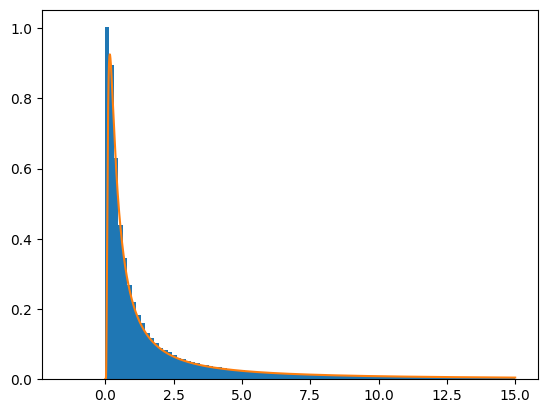

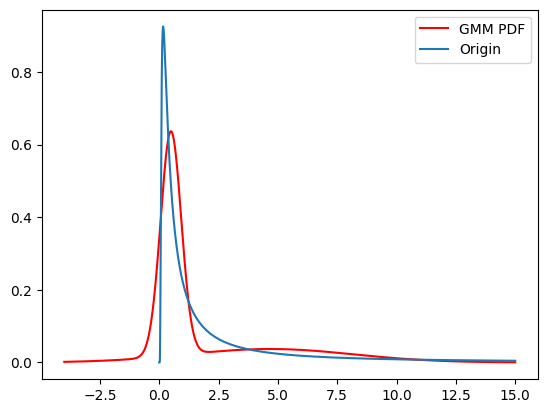

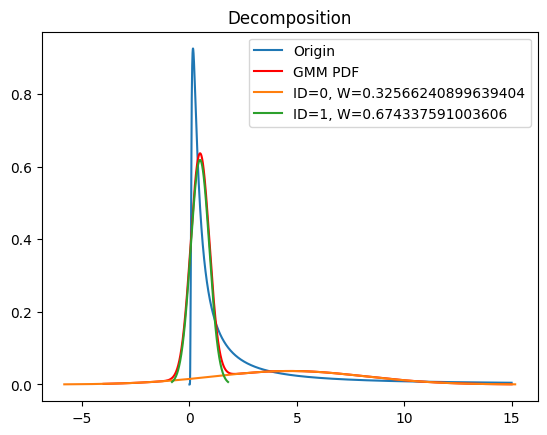

Math= 0.326 * Norm(4.670, 12.242) + 0.674 * Norm(0.494, 0.189)
Code= 0.326 * gassian_pdf(x, 4.670, 12.242) + 0.674 * gassian_pdf(x, 0.494, 0.189)


In [22]:
split_dist(levy_dist_pdf)